## TP0
Notebook for TP0

# Questions to Answer in the Analysis

## 1. About Pokéballs:
### a) What is the average capture probability for each Pokéball?
- Run the function **100 times per Pokémon** under ideal conditions **(HP: 100%, Level: 100)**.
- Calculate the **mean capture probability** for each Pokéball.


### b) Are some Pokéballs more or less effective depending on the Pokémon’s properties? Justify your answer.
- Compare each Pokéball’s effectiveness as a **proportion** of the standard **Pokéball’s** effectiveness for each Pokémon.



## 2. About the Pokémon’s State:
### a) Do health conditions (status effects) affect the effectiveness of capture? If so, which ones are the most and least effective?
- Test with **different status effects** (e.g., Sleep, Paralysis).
- Measure how they **impact capture probability**.

### b) How does HP percentage affect capture effectiveness?
- Choose **one or two Pokémon**.
- Keep all other parameters **constant**.
- Calculate the **capture probability at different HP% values**.

### c) Which parameters have the greatest impact on the probability of capture?
- Analyze the influence of:
  - Pokémon **catch rate**
  - Pokémon **weight**
  - **HP% level**
  - **Pokéball type**
  - **Status effect**

### d) For one or two different Pokémon: What is the best combination of conditions (mutable properties) and Pokéball to maximize the capture probability?
- Find the **optimal setup** (Pokéball + Status Effect + HP%) for capturing specific Pokémon.

### e) Based on the previous question, would a different combination of parameters be effective if the Pokémon were at a higher or lower level?
- Test whether capture effectiveness changes when the **Pokémon's level is higher or lower**.




In [2]:
# Necessary Imports
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.catching import attempt_catch
from src.pokemon import PokemonFactory, StatusEffect, Pokemon

In [104]:
# Variables
noise_levels = [0.0, 0.05, 0.1, 0.15]
pokeballs = ['pokeball', 'ultraball', 'fastball', 'heavyball']
pokemon_configs = ['caterpie', 'snorlax']
hp_percentages = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [105]:
# Simulate Attempts
def simulate_attempts(pokemon: Pokemon, pokeball: str, hp: int, attempts: int = 100, noise: float = 0, catch_rate: float = 0, weight: int = 0, pokemon_type=''):
    results = []
    for _ in range(attempts):
        success, probability = attempt_catch(pokemon, pokeball, noise)
        # print(f'Debug: {pokemon.name} | Pokeball: {pokeball} | HP%: {pokemon.current_hp} | Success: {success} | Probability: {probability}')
        results.append({
            'Pokemon': pokemon.name,
            'Pokeball': pokeball,
            'HP%': hp,
            'Status': pokemon.status_effect.name,
            'Capture_Success': success,
            'Capture_Probability': probability,
            'Noise': noise,
            'Catch_Rate': catch_rate,
            'Weight': weight,
            'Type': pokemon_type
        })
    return results

In [106]:
factory = PokemonFactory('pokemon.json')
pokemon_stats = pd.DataFrame(columns=['Pokemon', 'Pokeball', 'HP%', 'Status', 'Capture_Success', 'Capture_Probability', 'Noise', 'Catch_Rate', 'Weight', 'Type'])

# Load all Pokemon data
with open('pokemon.json', 'r') as f:
    pokemon_data = json.load(f)

# Iterate over Pokemon configurations
for pokemon_config in pokemon_configs:
    with open(f'configs/{pokemon_config}.json', 'r') as f:
        config = json.load(f)
        # ball = config['pokeball']
        pokemon_name = config['pokemon']

        # Extract Pokemon attributes from pokemon.json
        catch_rate = pokemon_data[pokemon_name]['catch_rate']
        weight = pokemon_data[pokemon_name]['weight']
        pokemon_type = ', '.join(pokemon_data[pokemon_name]['type'])

        for ball in pokeballs:
            for level in [50, 100, 150]:
                for status in [StatusEffect.NONE, StatusEffect.SLEEP, StatusEffect.PARALYSIS]:
                    for hp in hp_percentages:
                        for noise in noise_levels:
                            pokemon = factory.create(
                                pokemon_name, level, status, hp)
                            results = simulate_attempts(
                                pokemon, ball, int(hp * 100), 100, noise, catch_rate, weight, pokemon_type)
                            df = pd.DataFrame(results)
                            df['HP%'] = hp
                
                            pokemon_stats = pd.concat(
                                [pokemon_stats, df], ignore_index=True)

# Compute capture success rates
pokemon_stats['Capture_Success'] = pokemon_stats['Capture_Success'].astype(int)
success_rates = pokemon_stats.groupby('Pokeball')['Capture_Success'].mean()
summary_df = pokemon_stats.groupby(['Pokemon', 'Pokeball', 'HP%', 'Status', 'Noise', 'Catch_Rate', 'Weight', 'Type']).agg(
    Success_Rate=('Capture_Success', 'mean'),  # Mean success rate
    Avg_Capture_Probability=(
        'Capture_Probability', 'mean'),  # Mean probability
    Attempts=('Capture_Success', 'count')  # Number of attempts
).reset_index().round({'Success_Rate': 2, 'Avg_Capture_Probability': 2, 'Std_Capture_Probability': 3})

/var/folders/0s/w88y_lzx1fg5njq5380g9jfh0000gn/T/ipykernel_11123/3922846425.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pokemon_stats = pd.concat(


In [107]:
def generate_summary_table(df: pd.DataFrame, group_by_columns, table_name):
    summary = df.groupby(group_by_columns).agg(
        Success_Rate=('Capture_Success', 'mean'),  
        Avg_Capture_Probability=('Capture_Probability', 'mean'),
    ).reset_index()
    summary = summary.round({'Success_Rate': 3, 'Avg_Capture_Probability': 3, 'Std_Capture_Probability': 3})
    return summary

In [108]:
pokemon_stats

,Pokemon,Pokeball,HP%,Status,Capture_Success,Capture_Probability,Noise,Catch_Rate,Weight,Type
0,caterpie,pokeball,1.0,NONE,1,0.332100,0.00,255,6.4,"BUG, NONE"
1,caterpie,pokeball,1.0,NONE,1,0.332100,0.00,255,6.4,"BUG, NONE"
2,caterpie,pokeball,1.0,NONE,1,0.332100,0.00,255,6.4,"BUG, NONE"
3,caterpie,pokeball,1.0,NONE,0,0.332100,0.00,255,6.4,"BUG, NONE"
4,caterpie,pokeball,1.0,NONE,1,0.332100,0.00,255,6.4,"BUG, NONE"
...,...,...,...,...,...,...,...,...,...,...
287995,snorlax,heavyball,0.1,PARALYSIS,1,0.420547,0.15,25,1014.1,"NORMAL, NONE"
287996,snorlax,heavyball,0.1,PARALYSIS,1,0.361777,0.15,25,1014.1,"NORMAL, NONE"
287997,snorlax,heavyball,0.1,PARALYSIS,0,0.327310,0.15,25,1014.1,"NORMAL, NONE"
287998,snorlax,heavyball,0.1,PARALYSIS,1,0.348814,0.15,25,1014.1,"NORMAL, NONE"


In [109]:
summary_df

,Pokemon,Pokeball,HP%,Status,Noise,Catch_Rate,Weight,Type,Success_Rate,Avg_Capture_Probability,Attempts
0,caterpie,fastball,0.1,NONE,0.00,255,6.4,"BUG, NONE",0.94,0.93,300
1,caterpie,fastball,0.1,NONE,0.05,255,6.4,"BUG, NONE",0.92,0.93,300
2,caterpie,fastball,0.1,NONE,0.10,255,6.4,"BUG, NONE",0.91,0.91,300
3,caterpie,fastball,0.1,NONE,0.15,255,6.4,"BUG, NONE",0.90,0.90,300
4,caterpie,fastball,0.1,PARALYSIS,0.00,255,6.4,"BUG, NONE",1.00,1.00,300
...,...,...,...,...,...,...,...,...,...,...,...
955,snorlax,ultraball,1.0,PARALYSIS,0.15,25,1014.1,"NORMAL, NONE",0.13,0.10,300
956,snorlax,ultraball,1.0,SLEEP,0.00,25,1014.1,"NORMAL, NONE",0.15,0.13,300
957,snorlax,ultraball,1.0,SLEEP,0.05,25,1014.1,"NORMAL, NONE",0.13,0.13,300
958,snorlax,ultraball,1.0,SLEEP,0.10,25,1014.1,"NORMAL, NONE",0.14,0.13,300


In [ ]:
optimal_setup = pokemon_stats.groupby(['Pokemon', 'Pokeball', 'Status', 'HP%']).agg(
    Success_Rate=('Capture_Success', 'mean'),  # Probability of successful capture
    Avg_Capture_Probability=('Capture_Probability', 'mean')  # Average capture probability
).reset_index()

# Sort by Success Rate in descending order (best conditions first)
optimal_setup = optimal_setup.sort_values(by=['Pokemon', 'Success_Rate'], ascending=[True, False])
optimal_setup

,Pokemon,Pokeball,Status,HP%,Success_Rate,Avg_Capture_Probability
21,caterpie,fastball,SLEEP,0.2,1.000000,1.000000
22,caterpie,fastball,SLEEP,0.3,1.000000,1.000000
23,caterpie,fastball,SLEEP,0.4,1.000000,0.999603
51,caterpie,heavyball,SLEEP,0.2,1.000000,0.999959
52,caterpie,heavyball,SLEEP,0.3,1.000000,0.999823
...,...,...,...,...,...,...
187,snorlax,pokeball,NONE,0.8,0.047500,0.045874
128,snorlax,fastball,NONE,0.9,0.045000,0.039619
127,snorlax,fastball,NONE,0.8,0.044167,0.045854
189,snorlax,pokeball,NONE,1.0,0.033333,0.032508


### Capture Success Rate by Pokéball

In [ ]:
summary_by_ball = generate_summary_table(pokemon_stats, ['Pokeball', 'Pokemon'], "Success Rate by Pokéball & Pokémon")
summary_by_ball

,Pokeball,Pokemon,Success_Rate,Avg_Capture_Probability
0,fastball,caterpie,0.801,0.803
1,fastball,snorlax,0.091,0.093
2,heavyball,caterpie,0.767,0.768
3,heavyball,snorlax,0.244,0.242
4,pokeball,caterpie,0.806,0.803
5,pokeball,snorlax,0.089,0.093
6,ultraball,caterpie,0.978,0.978
7,ultraball,snorlax,0.191,0.186


In [131]:
summary_by_ball_single = generate_summary_table(pokemon_stats, ['Pokeball'], "Success Rate by Pokéball")
summary_by_ball_single

,Pokeball,Success_Rate,Avg_Capture_Probability
0,fastball,0.446,0.448
1,heavyball,0.505,0.505
2,pokeball,0.448,0.448
3,ultraball,0.584,0.582


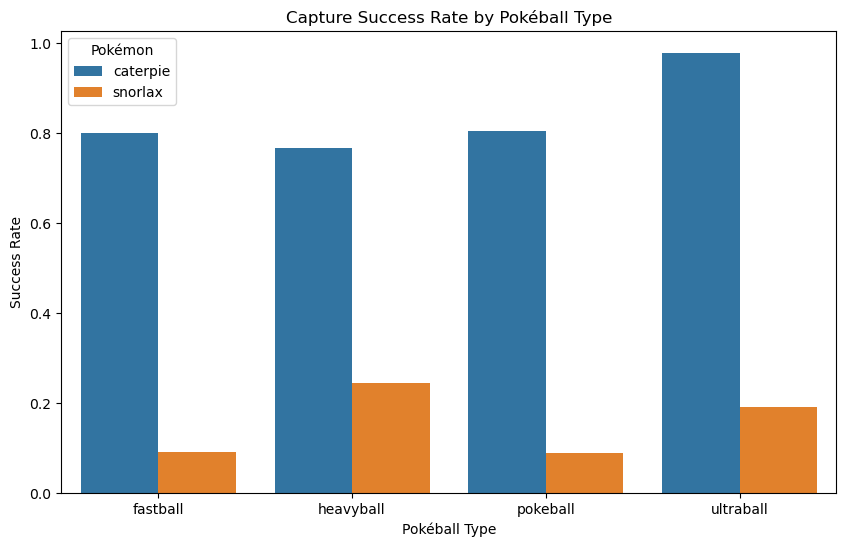

In [112]:
plt.figure(figsize=(10,6))
sns.barplot(x='Pokeball', y='Success_Rate', hue='Pokemon', data=summary_by_ball)
plt.xlabel('Pokéball Type')
plt.ylabel('Success Rate')
plt.title('Capture Success Rate by Pokéball Type')
plt.legend(title='Pokémon')
plt.show()

In [113]:
summary_by_hp = generate_summary_table(pokemon_stats, ['HP%', 'Pokemon'], "Success Rate by HP%")
summary_by_hp

,HP%,Pokemon,Success_Rate,Avg_Capture_Probability
0,0.1,caterpie,0.974,0.974
1,0.1,snorlax,0.229,0.226
2,0.2,caterpie,0.960,0.959
3,0.2,snorlax,0.212,0.210
4,0.3,caterpie,0.942,0.943
5,0.3,snorlax,0.191,0.195
6,0.4,caterpie,0.923,0.923
7,0.4,snorlax,0.175,0.178
8,0.5,caterpie,0.897,0.898
9,0.5,snorlax,0.162,0.162


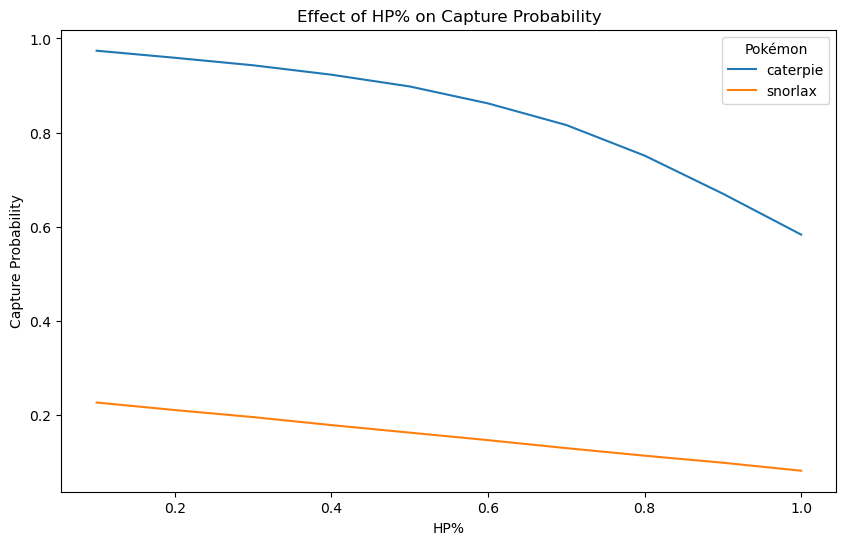

In [114]:
plt.figure(figsize=(10,6))
sns.lineplot(x='HP%', y='Avg_Capture_Probability', hue='Pokemon', data=summary_by_hp)
plt.xlabel('HP%')
plt.ylabel('Capture Probability')
plt.title('Effect of HP% on Capture Probability')
plt.legend(title='Pokémon')
plt.show()

### Capture Probability by Status Condition

In [115]:
summary_by_status = generate_summary_table(pokemon_stats, ['Status', 'Pokemon'], "Success Rate by Status Condition")
summary_by_status

,Status,Pokemon,Success_Rate,Avg_Capture_Probability
0,NONE,caterpie,0.694,0.694
1,NONE,snorlax,0.103,0.103
2,PARALYSIS,caterpie,0.873,0.873
3,PARALYSIS,snorlax,0.153,0.154
4,SLEEP,caterpie,0.946,0.946
5,SLEEP,snorlax,0.205,0.205


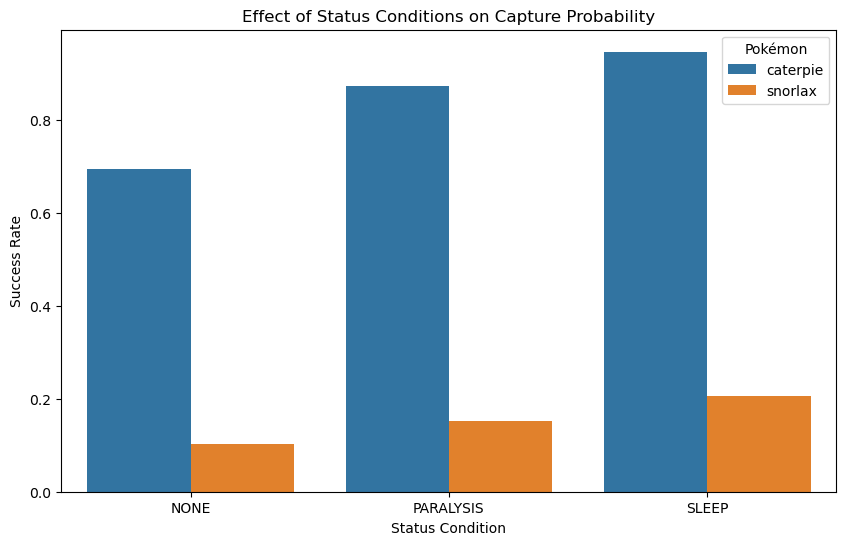

In [116]:
plt.figure(figsize=(10,6))
sns.barplot(x='Status', y='Success_Rate', hue='Pokemon', data=summary_by_status)
plt.xlabel('Status Condition')
plt.ylabel('Success Rate')
plt.title('Effect of Status Conditions on Capture Probability')
plt.legend(title='Pokémon')
plt.show()


### Capture Probability vs Catch Rate

In [119]:
summary_by_catch_rate = generate_summary_table(pokemon_stats, ['Catch_Rate', 'Pokemon'], "Success Rate by Catch Rate")
summary_by_catch_rate

,Catch_Rate,Pokemon,Success_Rate,Avg_Capture_Probability
0,25,snorlax,0.154,0.154
1,255,caterpie,0.838,0.838


### Capture Success Rate by Noise Level

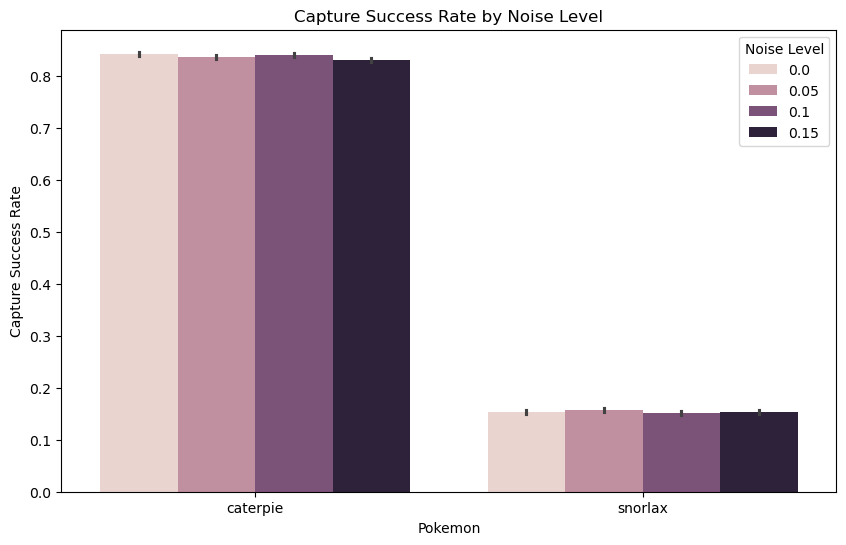

In [130]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Pokemon', y='Capture_Success',
            hue='Noise', data=pokemon_stats)
plt.xlabel('Pokemon')
plt.ylabel('Capture Success Rate')
plt.title('Capture Success Rate by Noise Level')
plt.legend(title='Noise Level')
plt.show()
